#  A. Temporal Patterns and Seasonality

### Some Preprocessing and Data CheckUps

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import zscore
from datetime import datetime 
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter, MonthLocator

#### Load the datasets

In [8]:
df_ev = pd.read_csv("data/cleaned_chargingdata.csv")
df_weather = pd.read_csv("data/cleaned_weather_data.csv")

#### Assign correct datatypes

In [9]:
df_ev['id'] = df_ev['id'].astype('string')

df_ev['connectionTime'] = pd.to_datetime(df_ev['connectionTime'], errors='coerce', utc=True)  
df_ev['disconnectTime'] = pd.to_datetime(df_ev['disconnectTime'], errors='coerce', utc=True)  
df_ev['doneChargingTime'] = pd.to_datetime(df_ev['doneChargingTime'], errors='coerce', utc=True) 

#df_ev['connectionTime'] = df_ev['connectionTime'].dt.tz_convert('America/Los_Angeles')
df_ev['disconnectTime'] = df_ev['disconnectTime'].dt.tz_convert('America/Los_Angeles')
df_ev['doneChargingTime'] = df_ev['doneChargingTime'].dt.tz_convert('America/Los_Angeles')

# df_ev['connectionTime'] = df_ev['connectionTime'].str.replace(r'(-08:00)|(-07:00)', '', regex=True)
# df_ev['disconnectTime'] = df_ev['disconnectTime'].str.replace(r'(-08:00)|(-07:00)', '', regex=True)
# df_ev['doneChargingTime'] = df_ev['doneChargingTime'].str.replace(r'(-08:00)|(-07:00)', '', regex=True)

# df_ev['sessionID'] = df_ev['sessionID'].astype('string')
df_ev['siteID'] = df_ev['siteID'].astype('string')
# df_ev['spaceID'] = df_ev['spaceID'].astype('string')
# df_ev['stationID'] = df_ev['stationID'].astype('string')
# df_ev['timezone'] = df_ev['timezone'].astype('string')
# df_ev['userID'] = df_ev['userID'].astype('string')

df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], errors='coerce', utc=True)
#df_weather['timestamp'] = df_weather['timestamp'].dt.tz_convert('America/Los_Angeles')

In [10]:
max_time_weather = df_weather['timestamp'].max()
min_time_weather = df_weather['timestamp'].min()
max_time_charging = df_ev['connectionTime'].max()
min_time_charging = df_ev['connectionTime'].min()
print("Max Time Weather:", max_time_weather)
print("Min Time Weather:", min_time_weather)
print("Max Time Charging:", max_time_charging)
print("Min Time Charging:", min_time_charging)

Max Time Weather: 2021-01-01 07:53:00+00:00
Min Time Weather: 2018-04-25 10:42:00+00:00
Max Time Charging: 2021-09-14 05:43:39+00:00
Min Time Charging: 2018-04-25 11:08:04+00:00


In [12]:
# start_time = max_time_weather - pd.DateOffset(years=1)
# end_time = max_time_charging - pd.DateOffset(years=1)
start_time = min_time_charging - pd.DateOffset(years=1)
end_time = max_time_weather - pd.DateOffset(years=1)
rows_to_duplicate = df_weather[(df_weather['timestamp'] >= start_time) &(df_weather['timestamp'] <= end_time)].copy()
rows_to_duplicate['timestamp'] = rows_to_duplicate['timestamp'] + pd.DateOffset(years=1)

Setting the `start_time` to higher Min Time and the `end_time` to the lower Max Time to ensure data from both datasets for each possible date.

In [13]:
df_weather = pd.concat([df_weather, rows_to_duplicate], ignore_index=True)
df_weather = df_weather.reset_index(drop=True)

In [14]:
def find_closest_weather(row):
    connection_time = row['connectionTime']
    time_diff = (df_weather['timestamp'] - connection_time).abs()
    closest_index = time_diff.idxmin()
    return df_weather.loc[closest_index]
closest_weather = df_ev.apply(find_closest_weather, axis=1)
weather_columns = ['timestamp', 'temperature', 'cloud_cover', 'cloud_cover_description', 'pressure', 'windspeed', 'precipitation','felt_temperature']
for col in weather_columns:
    df_ev[col] = closest_weather[col].values

This code aims to find the closest weather record (df_weather) for each charging record (df_ev) based on its charging time (connectionTime). To implementat this we:

- Define the function `find_closest_weather`, which takes a row from the charging record and calculates the time difference between connectionTime and weather timestamps. Returns the weather record with the smallest time difference.

- Apply the function to each row in df_ev, producing the closest weather record for each charging record.

- Merge the weather data with the charging records, appending the weather data (e.g., timestamp, temperature, cloud cover) column by column to `df_ev`.


In [15]:
max_row = df_ev[df_ev['connectionTime'] == max_time_charging]
print(max_row)

       Unnamed: 0.1  Unnamed: 0                        id  \
20172         20178        5875  6155053bf9af8b76960e16d1   

                 connectionTime            disconnectTime  \
20172 2021-09-14 05:43:39+00:00 2021-09-14 07:46:28-07:00   

               doneChargingTime  kWhDelivered  \
20172 2021-09-14 07:46:22-07:00        53.937   

                                    sessionID siteID  spaceID  ... userID  \
20172  1_1_178_817_2021-09-14 05:43:27.354300      1  AG-1F09  ...  500.0   

      chargingDuration           timestamp  temperature cloud_cover  \
20172       542.716667 2021-01-01 07:53:00         10.0        33.0   

       cloud_cover_description  pressure windspeed  precipitation  \
20172                     Fair     987.8       6.0            0.0   

       felt_temperature  
20172              10.0  

[1 rows x 22 columns]


In [16]:
df_ev['connectionTime']=df_ev['connectionTime'].dt.tz_convert('America/Los_Angeles')
df_weather['timestamp']=df_weather['timestamp'].dt.tz_convert('America/Los_Angeles')
print(df_weather['timestamp'].dtype)
print(df_ev['connectionTime'].dtype)

datetime64[ns, America/Los_Angeles]
datetime64[ns, America/Los_Angeles]


After all preprocessing for this Task is done, we finally convert the datetime to the correct timezones.

## Descriptive Calculations

### Hourly Calculations

In [17]:
Three_years_hourly_counts = df_ev.groupby(df_ev['connectionTime'].dt.hour).size()
Three_years_hourly_counts

connectionTime
0       149
1        86
2        71
3       126
4       436
5      2558
6      7935
7     11070
8      8122
9      6239
10     3811
11     2964
12     3611
13     3067
14     2559
15     2671
16     2424
17     1766
18     1724
19     1280
20      992
21      681
22      427
23      223
dtype: int64

We begin by analyzing the distribution of connection times. The data reveals that the majority of connections occur around 7 AM, indicating a peak usage period during the early morning hours.

C:\Users\Jan\AppData\Local\Temp\ipykernel_5044\4292505768.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start, end=end, freq='H')


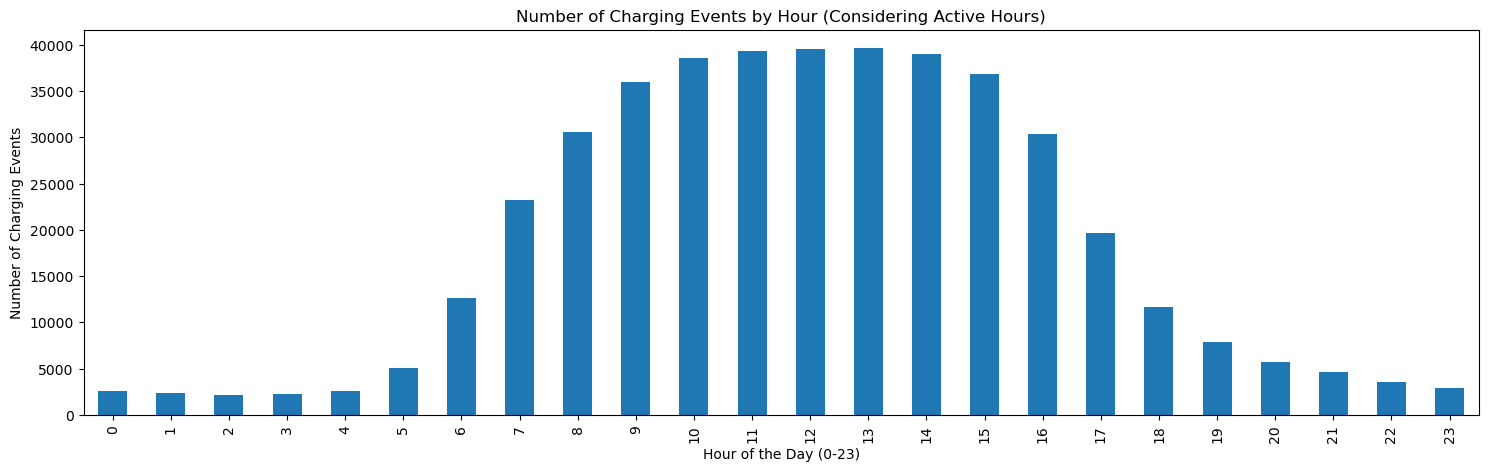

In [19]:
fig=plt.figure(figsize=(18,5))
def get_active_hours(row):
    start = row['connectionTime']
    end = row['disconnectTime']
    time_range = pd.date_range(start=start, end=end, freq='H')
    return [time.hour for time in time_range]
df_ev['active_hours'] = df_ev.apply(get_active_hours, axis=1)
all_hours = [hour for hours in df_ev['active_hours'] for hour in hours]
hourly_counts = pd.Series(all_hours).value_counts().sort_index()
hourly_counts.plot(kind='bar')
plt.title('Number of Charging Events by Hour (Considering Active Hours)')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Charging Events')
plt.xticks(range(24))
plt.show()

Furthermore, we analyze the number of charging events while accounting for active hours. 
Instead of focusing solely on the connection start time, we consider the entire duration of each charging session to gain a more comprehensive understanding of usage patterns.

In [53]:
number_of_days = len(set(df_ev['connectionTime'].dt.date))
print(number_of_days)
hourly_avg = Three_years_hourly_counts / number_of_days
hourly_avg = hourly_avg.round().astype(int)

1125


In [54]:
# Round to the nearest integer 
hourly_counts= hourly_avg.reset_index()
hourly_counts.columns = ['Hour', 'Vehicle_charging_Count']
hourly_counts

,Hour,Vehicle_charging_Count
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,2
6,6,7
7,7,10
8,8,7
9,9,6


<BarContainer object of 24 artists>

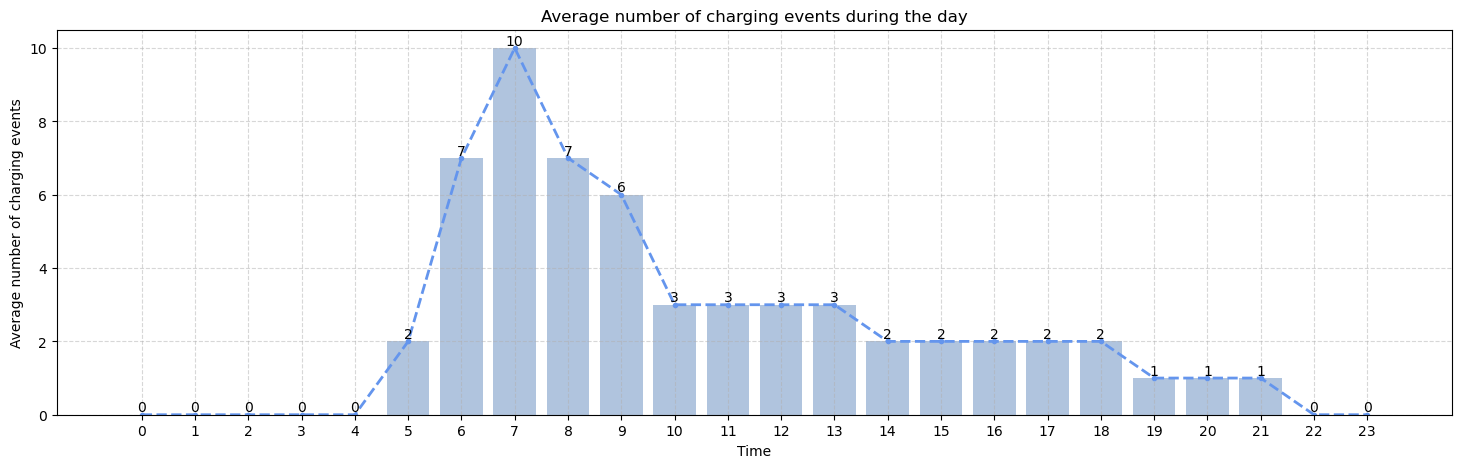

In [55]:
fig=plt.figure(figsize=(18,5))
x=hourly_counts['Hour']
y=hourly_counts['Vehicle_charging_Count']
plt.plot(x, y, color='cornflowerblue',marker='.',linestyle='--',linewidth=2,label='Line Chart')
plt.title('Average number of charging events during the day')
for (a,b) in zip(x,y):
    plt.text(x=a,y=b,s=b,ha='center',va='bottom')
plt.grid(ls="--",alpha=0.5)
plt.xticks(x)
plt.xlabel('Time')
plt.ylabel('Average number of charging events')
plt.bar(x,y,color='lightsteelblue')

By dividing the total number of charging sessions per hour over three years by the number of days, we can calculate the average hourly charging frequency, providing more insights into typical usage patterns across different times of the day.

### Weekly calculations

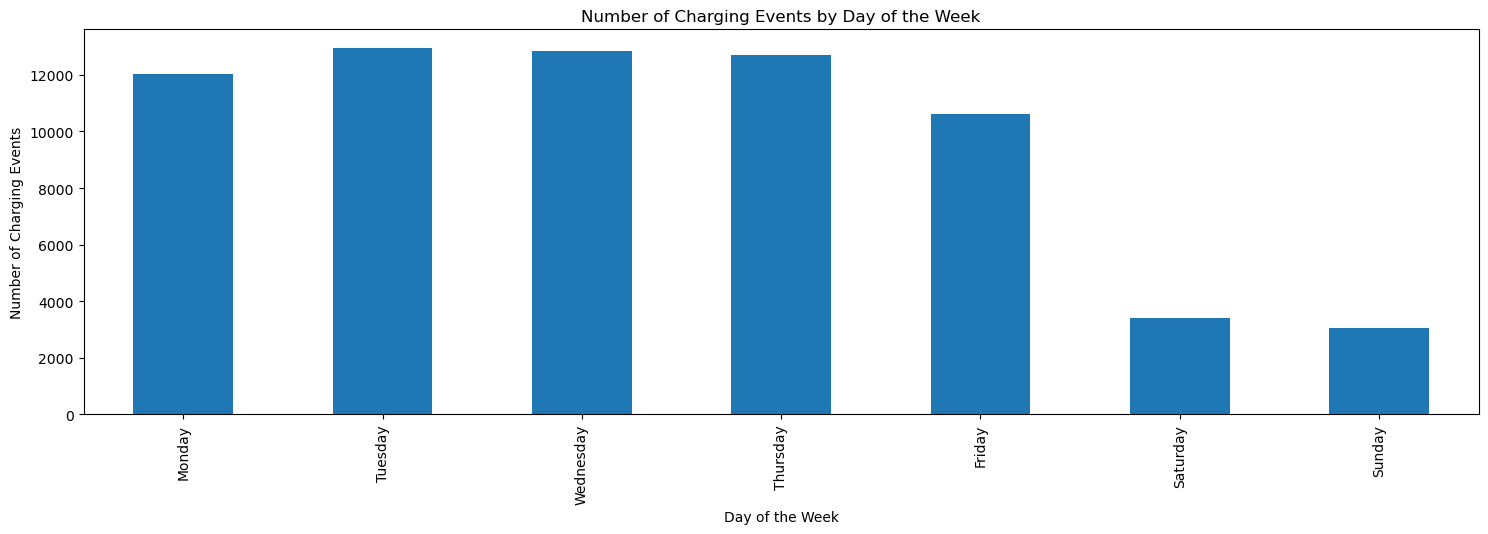

In [22]:
fig=plt.figure(figsize=(18,5))
def get_active_weekdays(row):
    start=row['connectionTime'].date()
    end=row['disconnectTime'].date()
    weekday_range=pd.date_range(start=start,end=end,freq='D')
    return [weekday.day_name() for weekday in weekday_range]
df_ev['active_weekday'] = df_ev.apply(get_active_weekdays,axis=1)
all_weekdays=[weekday for weekdays in df_ev['active_weekday'] for weekday in weekdays]
weekly_counts = pd.Series(all_weekdays).value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
weekly_counts.plot(kind='bar')
plt.title('Number of Charging Events by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Charging Events')
plt.show()

In [57]:
# the number of weekdays
unique_dates = df_ev['connectionTime'].dt.normalize().unique()
Monday_count =(pd.to_datetime(unique_dates).dayofweek == 0).sum()
print("Number of Mondays:",Monday_count)
Tuesday_count =(pd.to_datetime(unique_dates).dayofweek == 1).sum()
print("Number of Tuesdays:",Tuesday_count)
Wednesday_count =(pd.to_datetime(unique_dates).dayofweek == 2).sum()
print("Number of Wednesdays:",Wednesday_count)
Thursday_count =(pd.to_datetime(unique_dates).dayofweek == 3).sum()
print("Number of Thursdays:",Thursday_count)
Friday_count =(pd.to_datetime(unique_dates).dayofweek == 4).sum()
print("Number of Fridays:",Friday_count)
Saturday_count =(pd.to_datetime(unique_dates).dayofweek == 5).sum()
print("Number of Saturdays:",Saturday_count)
Sunday_count =(pd.to_datetime(unique_dates).dayofweek == 6).sum()
print("Number of Sundays:",Sunday_count)

Number of Mondays: 161
Number of Tuesdays: 160
Number of Wednesdays: 161
Number of Thursdays: 162
Number of Fridays: 162
Number of Saturdays: 160
Number of Sundays: 159


In [58]:
day_counts=pd.Series([Monday_count, Tuesday_count, Wednesday_count, Thursday_count, Friday_count, Saturday_count, Sunday_count],
                     index=['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'])
print(day_counts)

Mon      161
Tues     160
Wed      161
Thurs    162
Fri      162
Sat      160
Sun      159
dtype: int32


In [59]:
weekday = df_ev.groupby(df_ev['connectionTime'].dt.dayofweek).size()
weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
weekday

Mon      11762
Tues     12585
Wed      12458
Thurs    12268
Fri      10229
Sat       2992
Sun       2698
dtype: int64

In [60]:
average_numbe_of_charging=weekday/day_counts
average_numbe_of_charging=average_numbe_of_charging.round().astype(int)
print(average_numbe_of_charging)

Mon      73
Tues     79
Wed      77
Thurs    76
Fri      63
Sat      19
Sun      17
dtype: int32


In [61]:
Day_counts= average_numbe_of_charging.reset_index()
Day_counts.columns = ['Weekday', 'Vehicle_charging_Counts']
Day_counts

,Weekday,Vehicle_charging_Counts
0,Mon,73
1,Tues,79
2,Wed,77
3,Thurs,76
4,Fri,63
5,Sat,19
6,Sun,17


<BarContainer object of 7 artists>

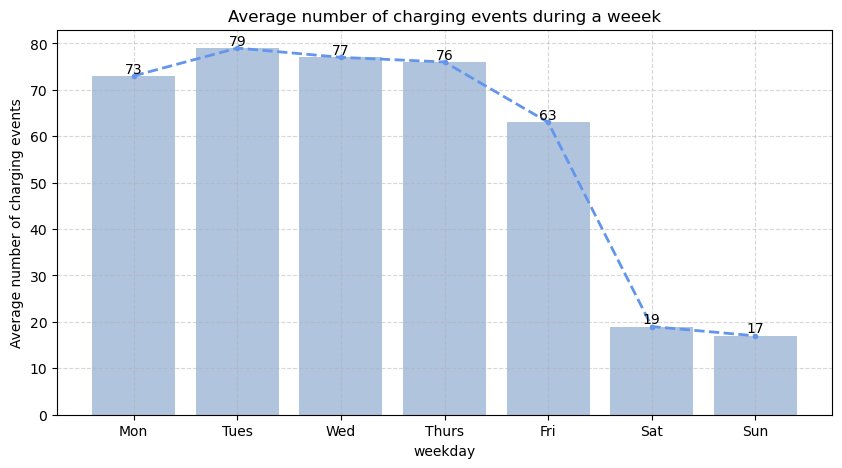

In [62]:
fig=plt.figure(figsize=(10,5))
x=Day_counts['Weekday']
y=Day_counts['Vehicle_charging_Counts']
plt.plot(x, y, color='cornflowerblue',marker='.',linestyle='--',linewidth=2,label='Line Chart')
plt.title('Average number of charging events during a weeek')
for (a,b) in zip(x,y):
    plt.text(x=a,y=b,s=b,ha='center',va='bottom')
plt.grid(ls="--",alpha=0.5)
plt.xticks(ticks=range(len(x)), labels=x)  
plt.xlabel('weekday')
plt.ylabel('Average number of charging events')
plt.bar(x,y,color='lightsteelblue')

### Monthly and seasonal calculations

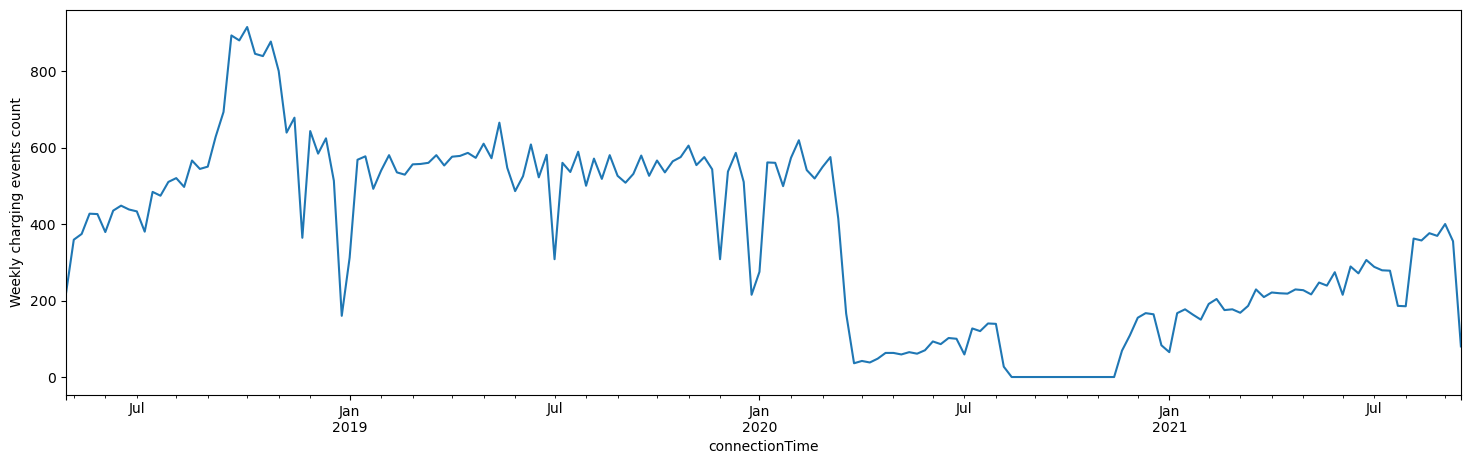

In [24]:
fig=plt.figure(figsize=(18,5))
# Set the connectionTime as the index
df_ev.set_index('connectionTime', inplace=True)

# resample according to week
weekly = df_ev.resample('W').size()
weekly.plot()
plt.ylabel('Weekly charging events count')
plt.rcParams['figure.figsize'] = 15, 5

# Reset the index to original
df_ev.reset_index(inplace=True)

To analyze seasonal and monthly trends, we plot the number of weekly charging events over the entire timeframe. This visualization reveals clear seasonal patterns, along with a significant drop at the onset of the COVID-19 pandemic. A gradual recovery is also observed after the initial decline, though charging activity has not yet returned to pre-pandemic levels.

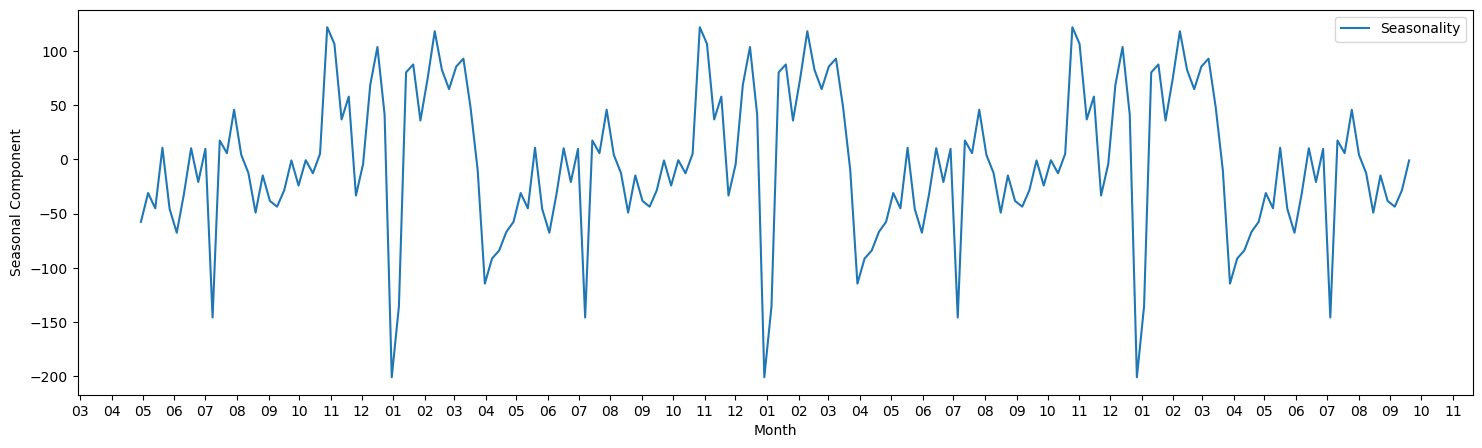

In [26]:
fig=plt.figure(figsize=(18,5))
decomposition = seasonal_decompose(weekly)
seasonal = decomposition.seasonal
ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%m')) 
ax.xaxis.set_major_locator(MonthLocator()) 
plt.xlabel('Month')  
plt.ylabel('Seasonal Component')   
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

This graph reveals a recurring annual pattern in the number of charging sessions. In spring, charging demand gradually declines as rising temperatures improve battery efficiency, reducing the need for frequent charging. During summer, demand surges, peaking in July or August, likely due to increased energy consumption from air conditioning and cooling systems. In autumn, charging frequency decreases once again as moderate temperatures enhance efficiency, leading to lower charging needs. Winter sees the lowest charging activity, particularly in January, possibly due to reduced commuting and workplace activity during major holidays like Christmas, New Year, and winter vacations.

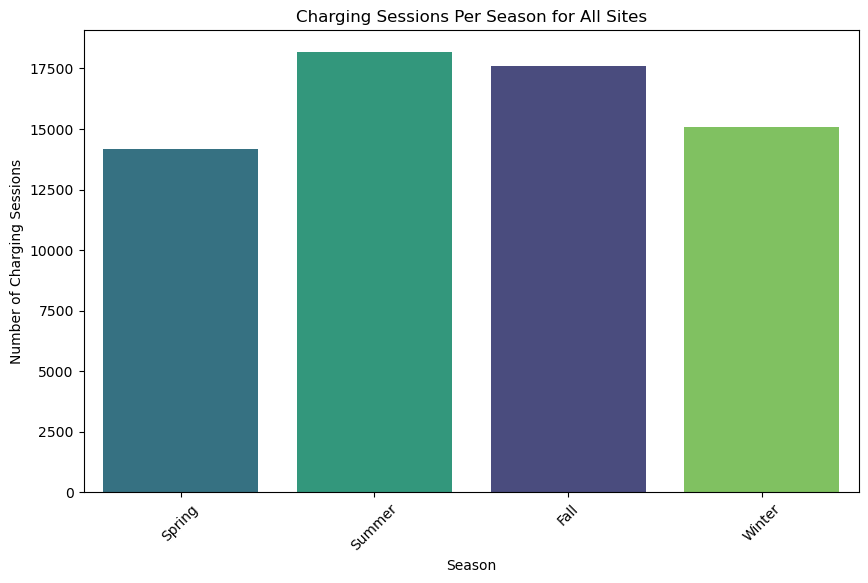

In [78]:
# extract the month
df_ev['month'] = df_ev['connectionTime'].dt.month

# Define the seasons based on months
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

df_ev['season'] = df_ev['month'].apply(get_season)

# Define the custom order for seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Group the data by season
season_data = df_ev.groupby('season').size().reset_index(name='session_count')

# Plot the number of charging sessions per season for all sites
plt.figure(figsize=(10, 6))
#sns.barplot(x='season', y='session_count', data=season_data, order=season_order, palette='viridis')
sns.barplot(x='season', y='session_count', hue='season', data=season_data, order=season_order, palette='viridis', dodge=False, legend=False)
plt.title('Charging Sessions Per Season for All Sites')
plt.xlabel('Season')
plt.ylabel('Number of Charging Sessions')
plt.xticks(rotation=45)
plt.show()

This graph visualizes the number of charging sessions per season, reinforcing the trends observed in the previous plot. It clearly highlights that charging activity is comparatively lower in both spring and winter.

### Correlation

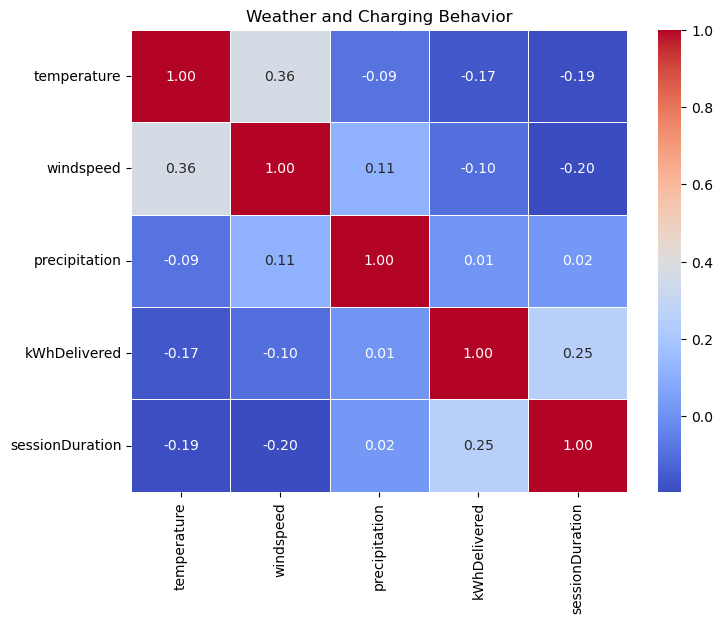

In [73]:
df_ev['sessionDuration'] = (df_ev['disconnectTime'] - df_ev['connectionTime']).dt.total_seconds() / 3600

correlation_data = df_ev[['temperature', 'windspeed', 'precipitation', 'kWhDelivered', 'sessionDuration']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Weather and Charging Behavior')
plt.show()


Lastly, we take a look at this correlation matrix. It can be observed that session duration and wind speed/temperature seem to have slight correlations. kWh delivered and temperature also seem to correlate slightly. However, these correlations appear to be too insignificant to make further assumptions.